# Imporing libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading data and preprocessing

In [ ]:
#reading data
data=pd.read_csv('/content/drive/MyDrive/amazon fine food reviews/Reviews.csv')

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#checking for null values
data.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [ ]:
#checking for duplicates
data.duplicated().sum()

0

<ipython-input-17-12ebe097640e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=data, palette='viridis')


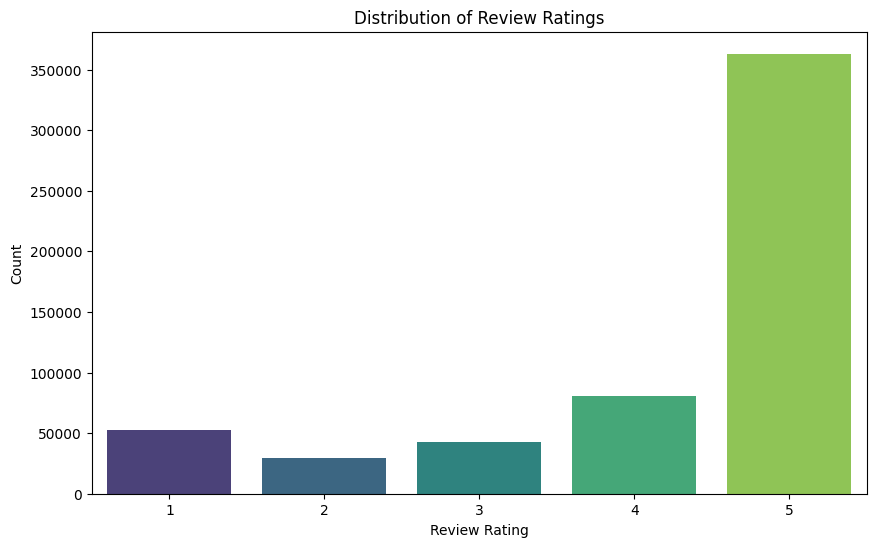

In [ ]:
#plotting the distribution of review ratings.
plt.figure(figsize=(10, 6))
sns.countplot(x='Score', data=data, palette='viridis')
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# 1- Separate the reviews by score (actual data, not the counts)
score_1 = data[data['Score'] == 1]
score_2 = data[data['Score'] == 2]
score_3 = data[data['Score'] == 3]
score_4 = data[data['Score'] == 4]
score_5 = data[data['Score'] == 5]

# 2- Define the desired sample size (smallest class size)
min_class_size = min(score_1.shape[0], score_2.shape[0], score_3.shape[0], score_4.shape[0], score_5.shape[0])

# 3- Downsample the majority classes (use actual subsets)
score_1_downsampled = resample(score_1, replace=False, n_samples=min_class_size, random_state=42)
score_2_downsampled = resample(score_2, replace=False, n_samples=min_class_size, random_state=42)
score_3_downsampled = resample(score_3, replace=False, n_samples=min_class_size, random_state=42)
score_4_downsampled = resample(score_4, replace=False, n_samples=min_class_size, random_state=42)
score_5_downsampled = resample(score_5, replace=False, n_samples=min_class_size, random_state=42)

# 4- Concatenate the downsampled dataframes
df_downsampled = pd.concat([score_1_downsampled, score_2_downsampled, score_3_downsampled, score_4_downsampled, score_5_downsampled])

# Shuffle the resulting dataframe
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# 5- Display the new class distribution
print(df_downsampled['Score'].value_counts())


Score
2    29769
1    29769
3    29769
5    29769
4    29769
Name: count, dtype: int64


In [ ]:
df_downsampled.shape

(148845, 10)

In [ ]:
def preprocess_text(text):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Load stopwords
    stop_words = set(stopwords.words('english'))
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join tokens back to form the cleaned sentence
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text

# Example usage
sample_text = "This is an example sentence, showing how preprocessing works!"
cleaned_text = preprocess_text(sample_text)
print(cleaned_text)


example sentence showing preprocessing work


In [ ]:
data['cleaned_text'] = data['Text'].apply(preprocess_text)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [ ]:
# Define the mapping from scores to sentiment labels
score_mapping = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

# Map the scores to sentiment labels
data['sentiment'] = data['Score'].map(score_mapping)

# Display the updated dataframe to verify
print(data[['Score', 'sentiment']].head())

   Score sentiment
0      5  positive
1      1  negative
2      4  positive
3      2  negative
4      5  positive


In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,sentiment,sentiment_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,positive,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,negative,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,positive,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,negative,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,positive,positive


In [ ]:
data.to_csv('/content/drive/MyDrive/amazon fine food reviews/Reviews(cleaned).csv', index=False)

# Loading the cleaned data (read the pre-proccessed file and Start the notebook from here )

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/amazon fine food reviews/Reviews(cleaned).csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,sentiment,sentiment_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,positive,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,negative,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,positive,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,negative,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,positive,positive


In [ ]:
X=df['cleaned_text']
Y=df['sentiment']

print(X.shape)
print(Y.shape)

(568454,)
(568454,)


#preparing data for model

In [ ]:
# First, split into training+validation and test sets (80% train+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Then, split the training+validation set into train and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Check the sizes of the splits
print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")


Training set size: 363810, Validation set size: 90953, Test set size: 113691


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(363810,)
(363810,)
(90953,)
(90953,)
(113691,)
(113691,)


In [ ]:
# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)  # Limit vocabulary size to 10,000 words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences for each set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a uniform length
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder
encoder = OneHotEncoder()

# Fit on the training data and transform it
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Only transform the validation and test data
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Convert the sparse matrices to dense arrays (if necessary)
y_train_encoded_dense = y_train_encoded.toarray()
y_val_encoded_dense = y_val_encoded.toarray()
y_test_encoded_dense = y_test_encoded.toarray()


In [ ]:
print(X_train_pad.shape)
print(y_train_encoded.shape)
print(X_test_pad.shape)
print(y_test_encoded.shape)
print(X_val_pad.shape)
print(y_val_encoded.shape)

(363810, 100)
(363810, 3)
(113691, 100)
(113691, 3)
(90953, 100)
(90953, 3)


# Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define the CNN-LSTM model architecture
model = Sequential()

# Embedding layer
vocab_size = 10000  # Adjust based on tokenizer vocab size
embedding_dim = 128  # Embedding vector size
maxlen = 100  # Length of padded sequences
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# Conv1D layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max Pooling layer
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(128, return_sequences=False))

# Dense layer
model.add(Dense(128, activation='relu'))

# Dropout layer
model.add(Dropout(0.5))

# Output layer for classification (e.g., 3 classes for sentiment)
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model (optional step to ensure the shapes are set)
model.build(input_shape=(None, maxlen))

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,510,531 (5.76 MB)

 Trainable params: 1,510,531 (5.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train_pad,                # Padded training sequences
    y_train_encoded_dense,      # Dense one-hot encoded training labels
    epochs=10,                  # Number of training epochs (adjust as needed)
    batch_size=64,              # Batch size for training
    validation_data=(X_val_pad, y_val_encoded_dense)  # Validation on validation data
)


Epoch 1/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - accuracy: 0.8189 - loss: 0.5333 - val_accuracy: 0.8727 - val_loss: 0.3420
Epoch 2/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 74s 9ms/step - accuracy: 0.8886 - loss: 0.3052 - val_accuracy: 0.8845 - val_loss: 0.3180
Epoch 3/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9179 - loss: 0.2297 - val_accuracy: 0.8969 - val_loss: 0.3050
Epoch 4/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step - accuracy: 0.9422 - loss: 0.1679 - val_accuracy: 0.8892 - val_loss: 0.3272
Epoch 5/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.9589 - loss: 0.1227 - val_accuracy: 0.8997 - val_loss: 0.3703
Epoch 6/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - accuracy: 0.9698 - loss: 0.0922 - val_accuracy: 0.8984 - val_loss: 0.3962
Epoch 7/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - accuracy: 0.9768 - loss: 0.0723 - val_accuracy: 0.8987 - val_loss: 0.4208
Epoch 8/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9816 - 

In [ ]:
# Save themodel
model.save('/content/drive/MyDrive/amazon fine food reviews/my_model.h5')

In [ ]:
# Save the model weights
model.save_weights('/content/drive/MyDrive/amazon fine food reviews/my_model.weights.h5')


# Testing

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded_dense)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8958 - loss: 0.5367
Test Loss: 0.5341
Test Accuracy: 89.62%


# Visualizations

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


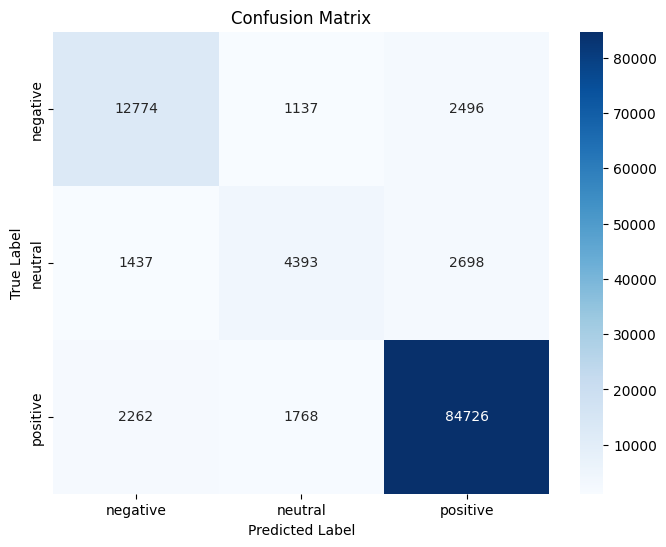

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred_probs = model.predict(X_test_pad)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test_encoded_dense, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(np.argmax(y_test_encoded_dense, axis=1), y_pred, target_names=encoder.categories_[0]))


              precision    recall  f1-score   support

    negative       0.78      0.78      0.78     16407
     neutral       0.60      0.52      0.56      8528
    positive       0.94      0.95      0.95     88756

    accuracy                           0.90    113691
   macro avg       0.77      0.75      0.76    113691
weighted avg       0.89      0.90      0.89    113691



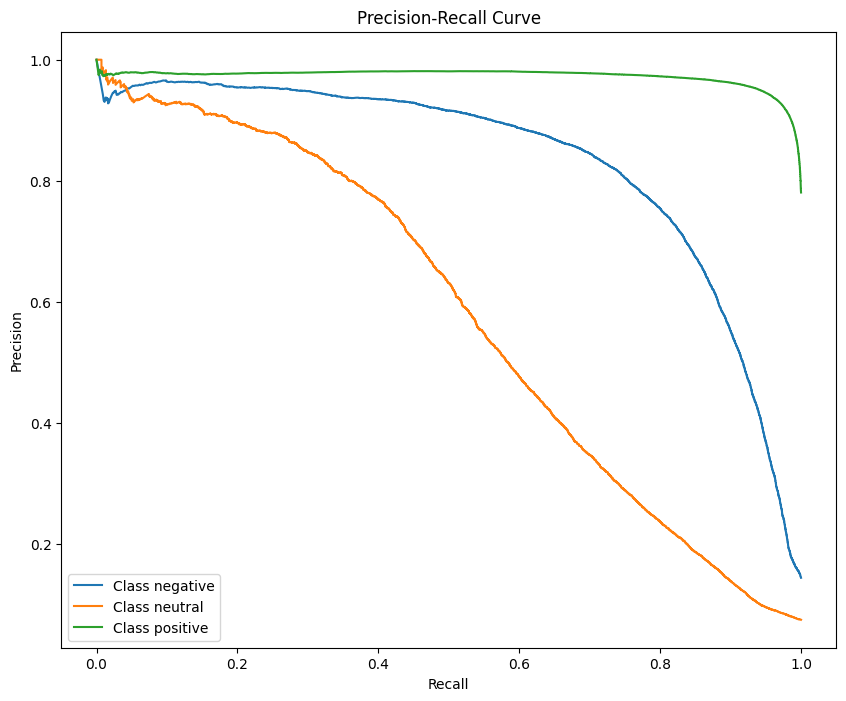

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_encoded_dense[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label='Class {0}'.format(encoder.categories_[0][i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Number of classes in encoder: 3
Number of classes in report: 5


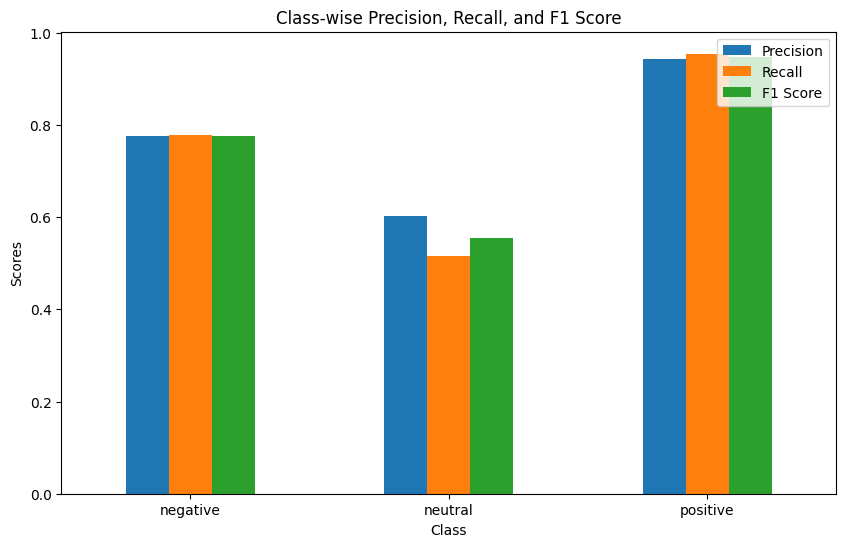

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Get the classification report as a DataFrame
report_dict = classification_report(np.argmax(y_test_encoded_dense, axis=1), y_pred, target_names=encoder.categories_[0], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Get class-wise metrics
class_names = encoder.categories_[0]
n_classes = len(class_names)

# Check the lengths
print(f"Number of classes in encoder: {n_classes}")
print(f"Number of classes in report: {len(report_df) - 1}")  # Exclude the 'accuracy' row

# Ensure you only include metrics for the existing classes
precision = report_df['precision'][:n_classes]  # Only take as many as exist
recall = report_df['recall'][:n_classes]
f1_score = report_df['f1-score'][:n_classes]

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision.values,
    'Recall': recall.values,
    'F1 Score': f1_score.values
})

# Set index
metrics_df.set_index('Class', inplace=True)

# Plot
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Class-wise Precision, Recall, and F1 Score')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()
